# Chapter 8: Decision Trees - Classification

## 8.1.2 Classification Trees
Decision trees are created and fitted to a dataset using a process known as recursive binary splitting in which the predictor space  $X_1, X_2, \ldots, X_p$ is divided into distinct and non-overlapping regions $R_1, R_2, \ldots, R_J$. 
For a classification tree, we predict that each observation belongs to the most commonly occurring class of training observations in the region  $R_i$ to which it belongs.
These regions are chosen to minimize the *classification error rate*  that is simply the fraction of the training observations in that region that do not belong to the most common class:

$E = 1- \text{max}_k(\hat{p}_{mk})$

where $\hat{p}_{mk}$ represents the proportion of training observations in the $m$th region that are from the $k$th class. However, it turns out that classification error is not sufficiently sensitive for tree-growing, and in practice two other measures are preferable.

 - The Gini index is defined by:
 
     $G = \sum^K_{k=1}\hat{p}_{mk}(1-\hat{p}_{mk})$
     
   It is not hard to see that the Gini index takes on a small value if all of the pˆmk’s are close to zero or one. For this reason the Gini index is referred to as a measure of node purity—a small value indicates that a node contains predominantly observations from a single class.
   
 
 - An alternative to the Gini index is entropy, given by
     $D = -\sum^K_{k=1}\hat{p}_{mk}\log\hat{p}_{mk}$
     
    the entropy will take on a value near zero if the $\hat{p}_{mk}$’s are all near zero or near one. Therefore, like the Gini index, the entropy will take on a small value if the mth node is pure. In fact, it turns out that the Gini index and the entropy are quite similar numerically.
    
When building a classification tree, either the Gini index or the entropy are typically used to evaluate the quality of a particular split, since these two approaches are more sensitive to node purity than is the classification error rate.

## Dataset: 'Carseats'

In [1]:
#install.packages('tree')
library(tree)

In [2]:
library(ISLR2)

We first use classification trees to analyze the Carseats data set.

In [3]:
attach(Carseats)

In [4]:
head(Carseats)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No
6,10.81,124,113,13,501,72,Bad,78,16,No,Yes


 In these data, *Sales* is a continuous variable, and so we begin by recoding it as a binary variable. We use the *ifelse()* function to create a variable, called *High*, which takes on a value of Yes if the *Sales* variable exceeds 8, and takes on a value of *No* otherwise.

In [5]:
High <- factor(ifelse(Sales <= 8, "No", "Yes"))

Finally, we use the *data.frame()* function to merge *High* with the rest of the *Carseats* data.

In [6]:
Carseats <- data.frame(Carseats, High)

## Fitting classification trees


We now use the *tree()* function to fit a classification tree in order to predict High using all variables but *Sales*. The syntax of the *tree()* function is quite similar to that of the *lm()* function.

### Fit a classification tree to the entire dataset

In [7]:
#Fit the entire dataset
tree.carseats <- tree(High ~. -Sales, Carseats)

In [8]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

In [10]:
#This prints out all nodes and leaves
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

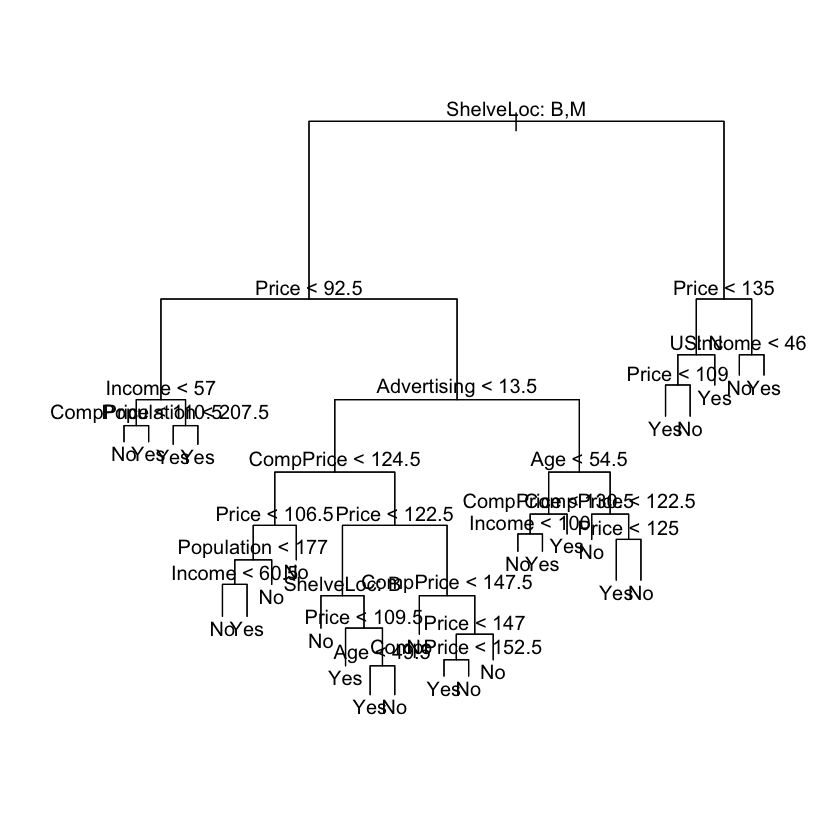

In [9]:
plot(tree.carseats)
text(tree.carseats, pretty = 1)

### Fit a classification tree to the train set only

In [11]:
#Use train-test split and fit the tree to only the train set
 set.seed(2)
train <- sample(1:nrow(Carseats), 200)
Carseats.test <- Carseats[-train, ]

In [12]:
 High.test <- High[-train]

In [14]:
tree.carseats <- tree(High ~ . - Sales, Carseats,
subset = train)

In [15]:
tree.pred <- predict(tree.carseats, Carseats.test,
type = "class")

In [16]:
table(tree.pred, High.test)

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

In [17]:
#The accuracy is 77%
(104+50)/(104+50+13+33)

[1] 0.77

### Tree pruning with cross validation

 The function *cv.tree()* performs cross-validation in order to determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration. We use the argument *FUN = prune.misclass* in order to indicate that we want the classification error rate to guide the cross-validation and pruning process, rather than the default for the *cv.tree()* function, which is deviance.

In [18]:
set.seed(7)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)
names(cv.carseats)

[1] "size"   "dev"    "k"      "method"

The *cv.tree()* function reports the number of terminal nodes of each tree considered (size) as well as the corresponding error rate and the value of the cost-complexity parameter used. Despite its name, dev corresponds to the number of cross-validation errors. The tree with 9 terminal nodes results in only 74 cross-validation errors.

In [19]:
cv.carseats

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 75 75 75 74 82 83 83 85 82

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

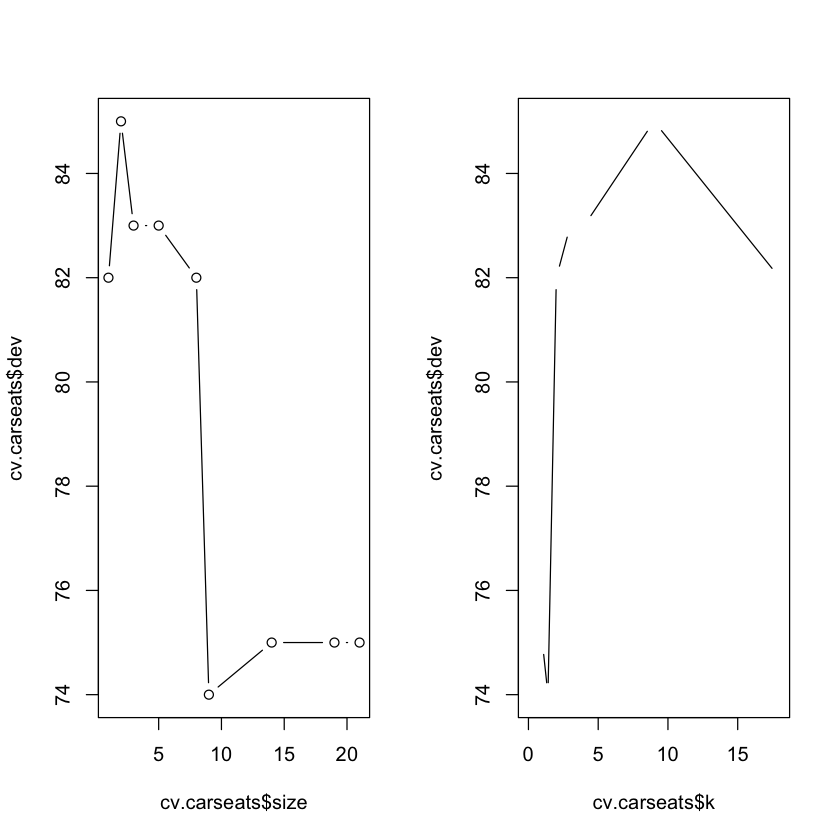

In [21]:
par(mfrow=c(1,2))
plot(cv.carseats$size, cv.carseats$dev, type = 'b')
plot(cv.carseats$k, cv.carseats$dev, type = 'c')

We now apply the *prune.misclass()* function in order to prune the tree to obtain the nine-node tree.

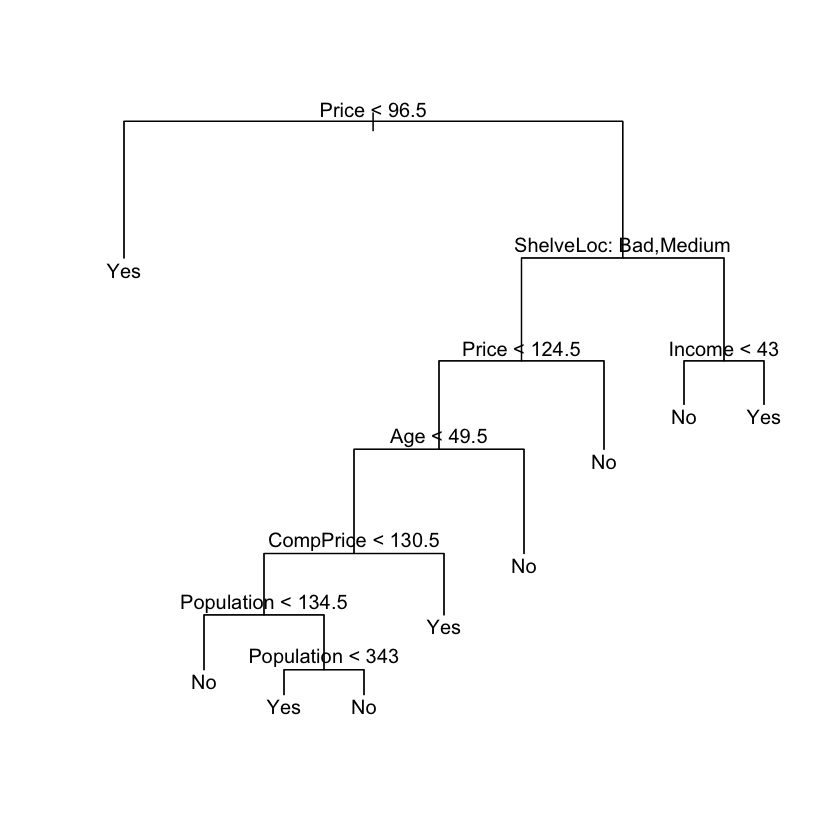

In [22]:
prune.carseats <- prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty =0)

In [23]:
#Check the performance of the pruned tree on the test dataset
tree.pred <- predict(prune.carseats, Carseats.test, type = 'class')
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

In [24]:
#The accuracy is increased slightly to 77.5%
(97+58)/(97+58+25+20)

[1] 0.775

# References

Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani, **An Introduction to Statistical Learning
with Applications in R**, Chapter 8. 